In [1]:
### Make the plot of snow depth

import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd
import copy
import glob
from datetime import date
from datetime import datetime

### Define Functions ###

# Function to return the day number
# of the year for the given date
def dayOfYear(date):
    
    days = [31, 28, 31, 30, 31, 30,
        31, 31, 30, 31, 30, 31];
     
    # Extract the year, month and the
    # day from the date string
    year = (int)(date[0:4]);
    month = (int)(date[5:7]);
    day = (int)(date[8:]);
 
    # If current year is a leap year and the date
    # given is after the 28th of February then
    # it must include the 29th February
    if (month > 2 and year % 4 == 0 and
       (year % 100 != 0 or year % 400 == 0)):
        day += 1;
 
    # Add the days in the previous months
    month -= 1;
    while (month > 0):
        day = day + days[month - 1];
        month -= 1;
    return day;

# Function used to load current year data
def snowpackOnDate(stationNames,dataPath,snowDepthDict,datesDict):
    dataOnDate = pd.read_csv(dataPath, sep = "|",header=1)
    
    for name in stationNames:
        # Station is in the text file
        if sum(dataOnDate.Station_Id == name) > 0:
            snowpack = dataOnDate[dataOnDate.Station_Id == name].Amount.values[0]
            dateString = dataOnDate[dataOnDate.Station_Id == name]['DateTime_Report(UTC)'].values[0][:-3]
            snowDepthDict[name] =  np.append(snowDepthDict[name],snowpack)
            datesDict[name] =  np.append(datesDict[name],dayOfYear(dateString))
        # Station is not in the text file
    return snowDepthDict,datesDict

def historicSeasonStrings(seasonStrings,snowDepth):
    currString = ''
    for i in range(len(seasonStrings)):
        if i<len(seasonStrings)-1:
            currString = currString + '{}: {} \n'.format(seasonStrings[i],round(snowDepth[i],1))
        else:
            currString = currString + '{}: {}'.format(seasonStrings[i],round(snowDepth[i],1))
    return currString

In [2]:
### Load Data ###
currentYear = datetime.now().year
currentMonth = datetime.now().month
if currentMonth>9:
    currentYear = currentYear + 1

###########
# Available Stations

# These are all the stations that we are pulling daily data for
# availableStations = ['HVCN3','HTLN3','GKBN3','CRNN3','KMWN','ZFHN3',
#                     'CAWN3','NH-CR-26','ESDN3','GHMN3','NH-CR-41','TMWN3',
#                     'NH-CR-11','NCON3','NH-CR-27','LLHN3','HUBN3','NH-CR-15',
#                     'NH-CS-19','NH-CR-46','NH-BK-26','NH-CR-46','NH-GR-47','WENN3',
#                     'NH-BK-9','MMNV1','MMSV1','NH-GR-11']

# These are the stations with historical data available
availableStationsDict = {'HTLN3':'hermitLake','CAWN3':'crawfordNotch','GHMN3':'pinkhamNotch',
                         'KMWN':'mountWashington'}

# Full names of the available stations
availableStationsFullName = {'HTLN3':'Hermit Lake','CAWN3':'Crawford Notch','GHMN3':'Pinkham Notch',
                         'KMWN':'Mount Washington'}
###########

In [5]:
#############################################################################

##### Iterate through each of the available stations, make a plot, and save it #####

stationCodeList = list(availableStationsDict.keys())

### Load data for the current year ###
currentSeasonSnowDepthDict_CM = {}
for stat in stationCodeList:
    currentSeasonSnowDepthDict_CM[stat] = np.array([])

currentSeasonDatesDict = {}
for stat in stationCodeList:
    currentSeasonDatesDict[stat] = np.array([])
    
dir_path = 'data/{}/*.txt'.format(currentYear) # path with the daily downloads of data, select the 12Z (morning EST)

for ifile,file in enumerate(glob.glob(dir_path, recursive=True)):
    currentSeasonSnowDepthDict_CM,currentSeasonDatesDict = snowpackOnDate(stationCodeList,file,
                                                                            currentSeasonSnowDepthDict_CM,currentSeasonDatesDict)
# Make it so that currentSeasonDatesDict has Sept 1 as day 1
adjustToSept1 = 122 # want sept 1 to be day 1
currentSeasonDatesDict = {i:currentSeasonDatesDict[i]+adjustToSept1 for i in currentSeasonDatesDict.keys()}
for name in stationCodeList: 
    currVal = currentSeasonDatesDict[name]
    currVal[currVal>365] = currVal[currVal>365]-365
    currentSeasonDatesDict[name] = currVal
    
# Add NANs where station data is missing
# this can make the plots hard to read
addNANs = False
if addNANs:
    for stat in stationCodeList:
        for d in range(1,366):
            if d in currentSeasonDatesDict[stat]:
                pass
            else:
                currentSeasonDatesDict[stat] = np.append(currentSeasonDatesDict[stat],d)
                currentSeasonSnowDepthDict_CM[stat] = np.append(currentSeasonSnowDepthDict_inCM[stat],np.nan)

# Convert to inches
currentSeasonSnowDepthDict_IN = {i:currentSeasonSnowDepthDict_CM[i]/2.54 for i in currentSeasonSnowDepthDict_CM.keys()}

# Sort the current season data according to the dates
for name in stationCodeList:
    sortInds = np.argsort(currentSeasonDatesDict[name])
    currentSeasonDatesDict[name] = currentSeasonDatesDict[name][sortInds]
    currentSeasonSnowDepthDict_IN[name] = currentSeasonSnowDepthDict_IN[name][sortInds]

/var/folders/z3/3r3w7vf55pbbxk0zx15bxx0r0000gn/T/ipykernel_17639/2738489012.py:10: RuntimeWarning: Mean of empty slice
  averageSnowDepth_IN = np.nanmean(snowDepthClim_IN,axis=0)


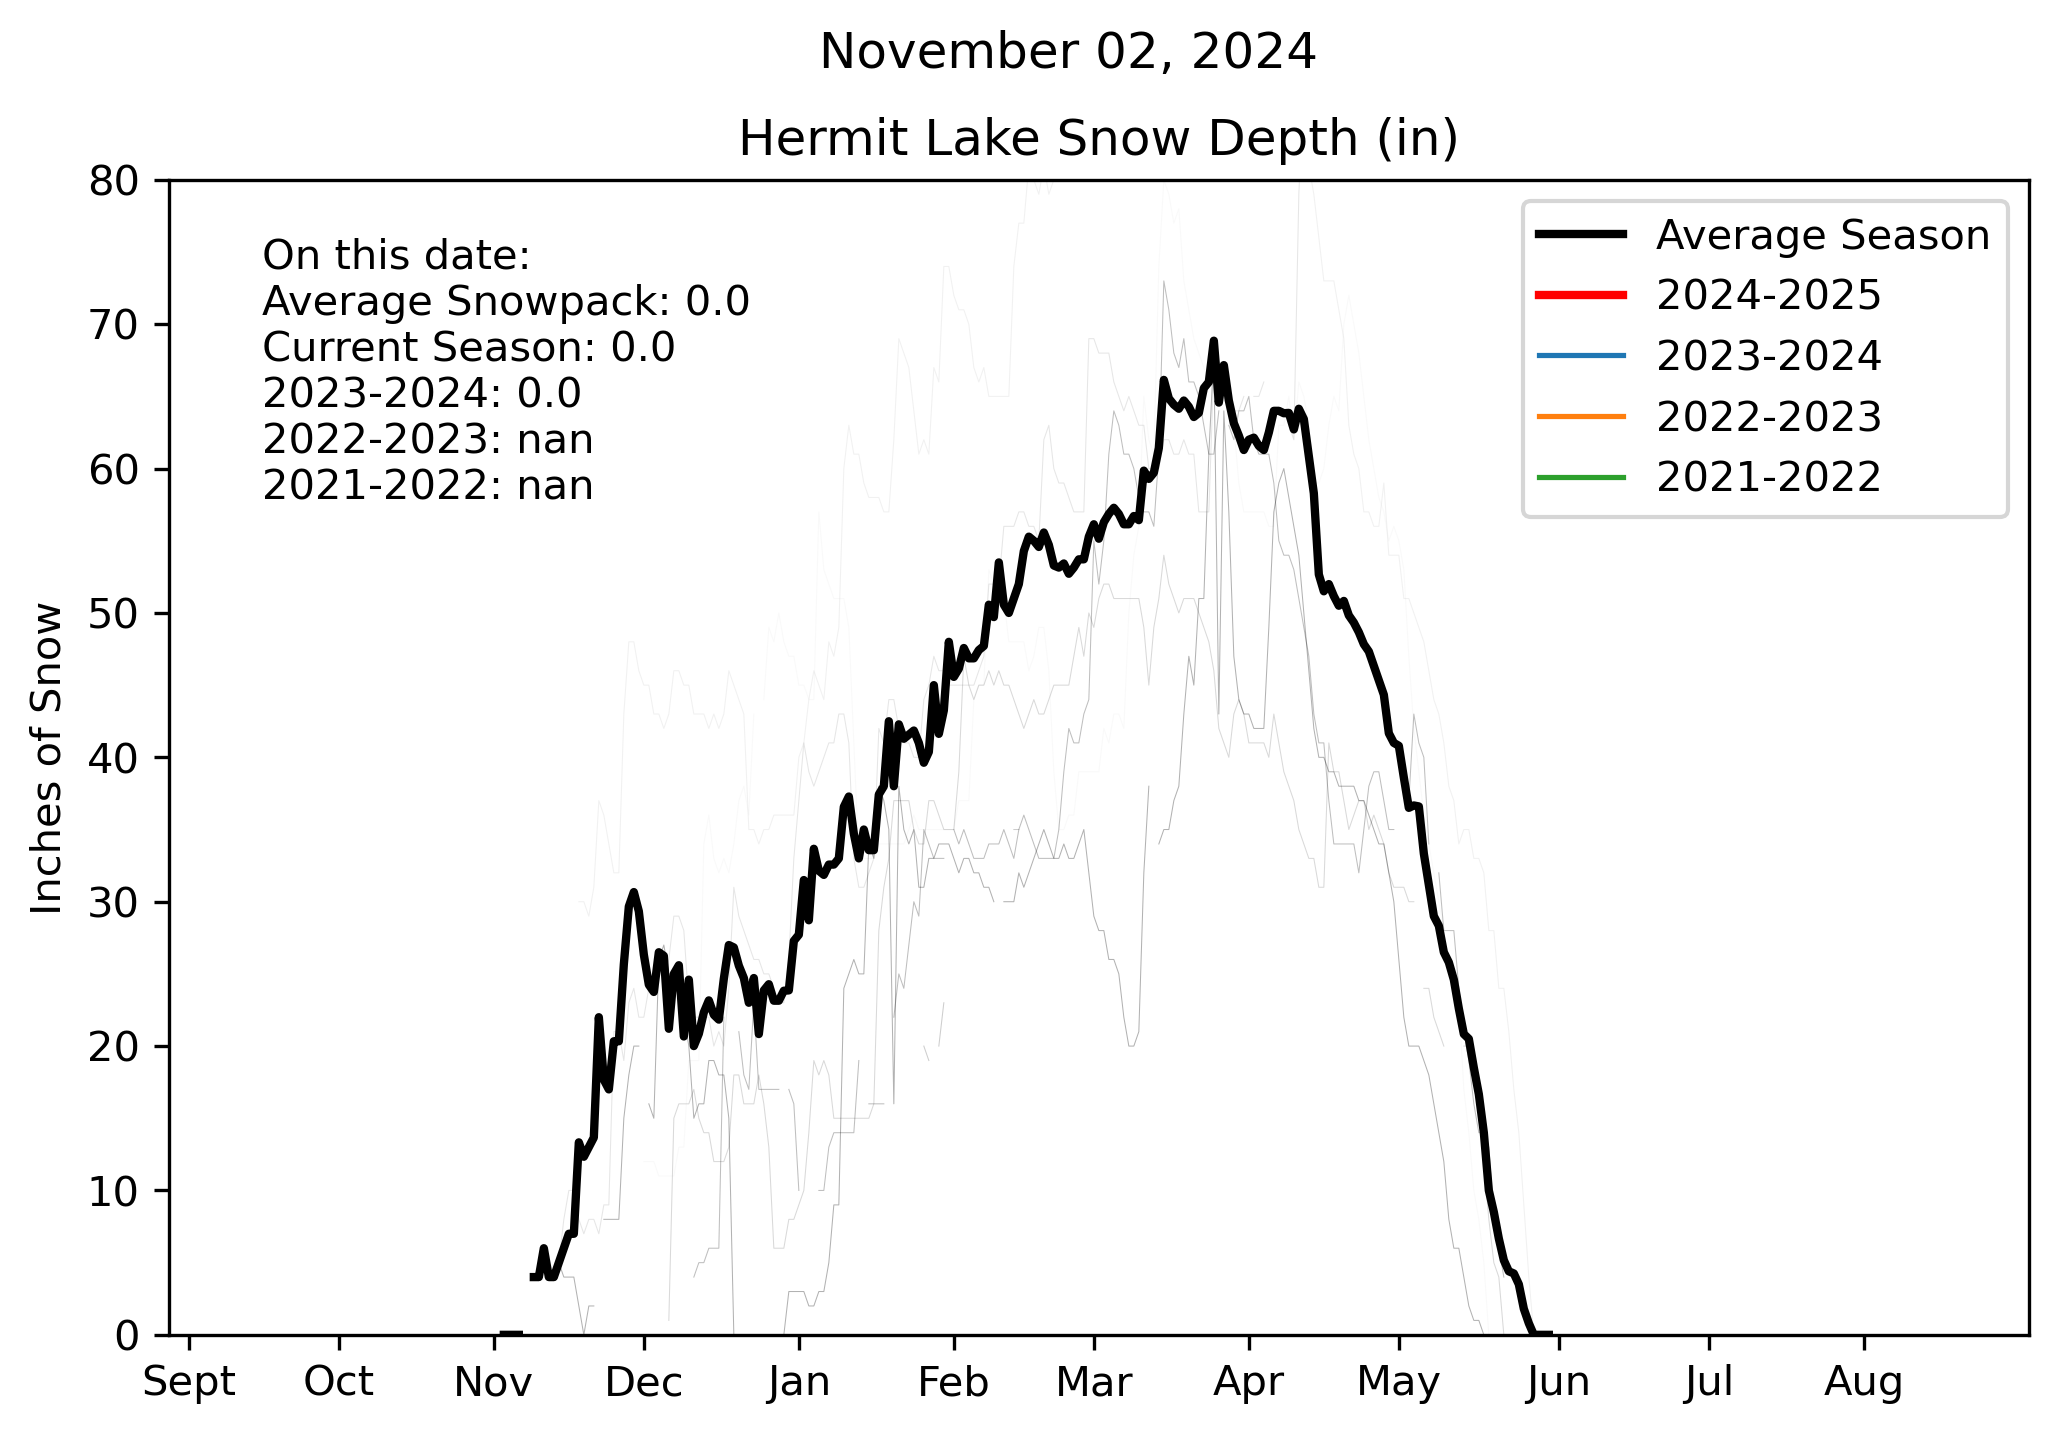

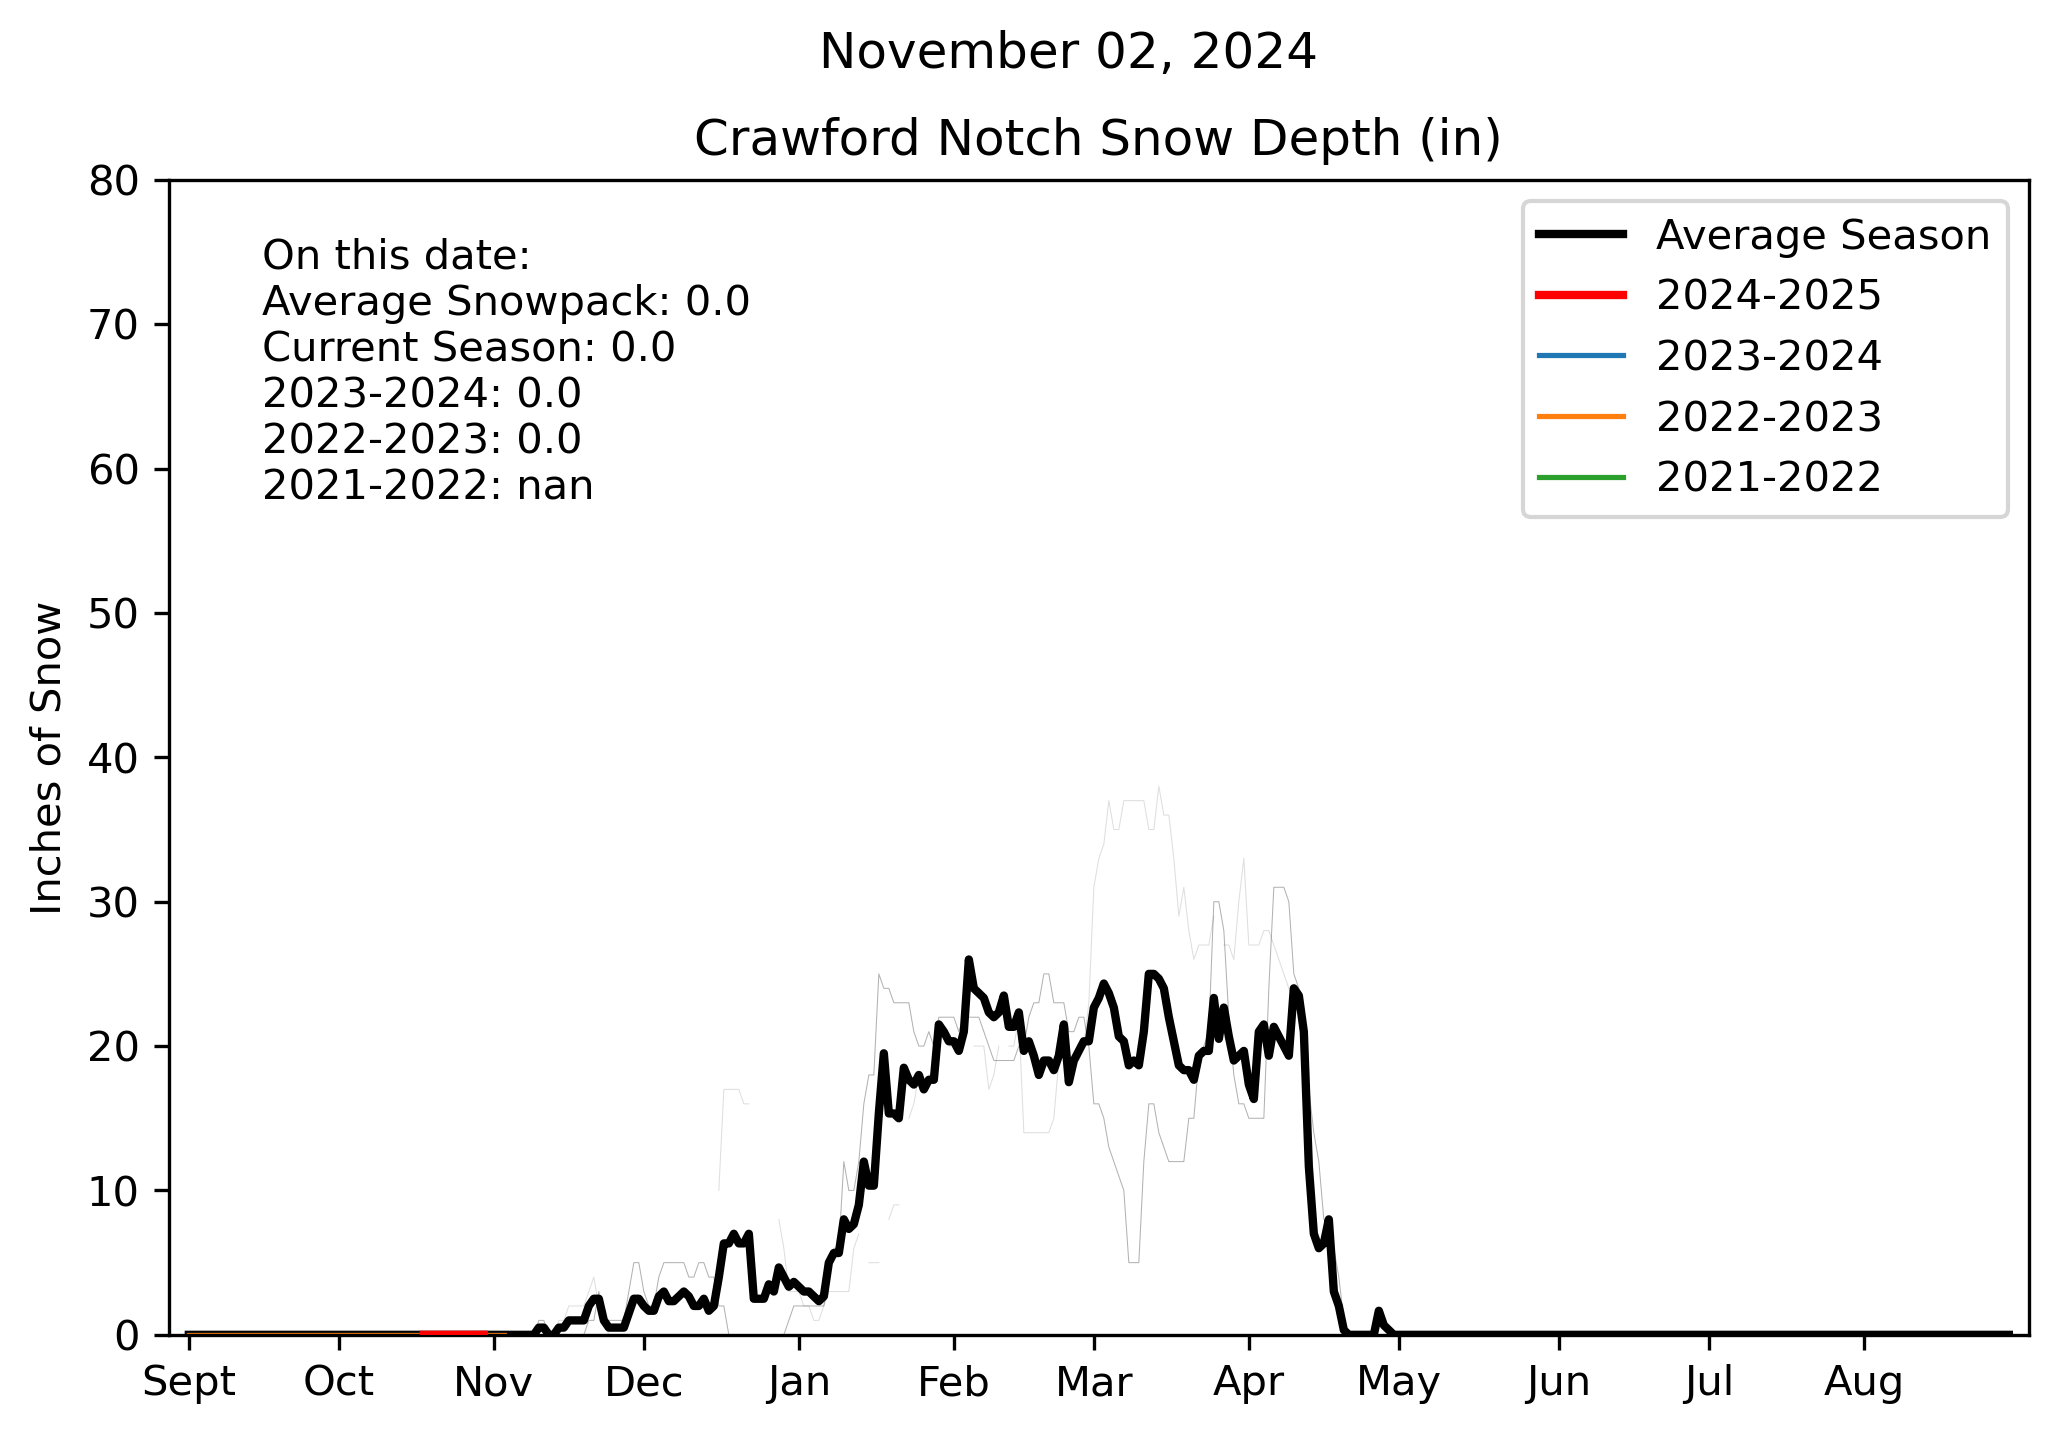

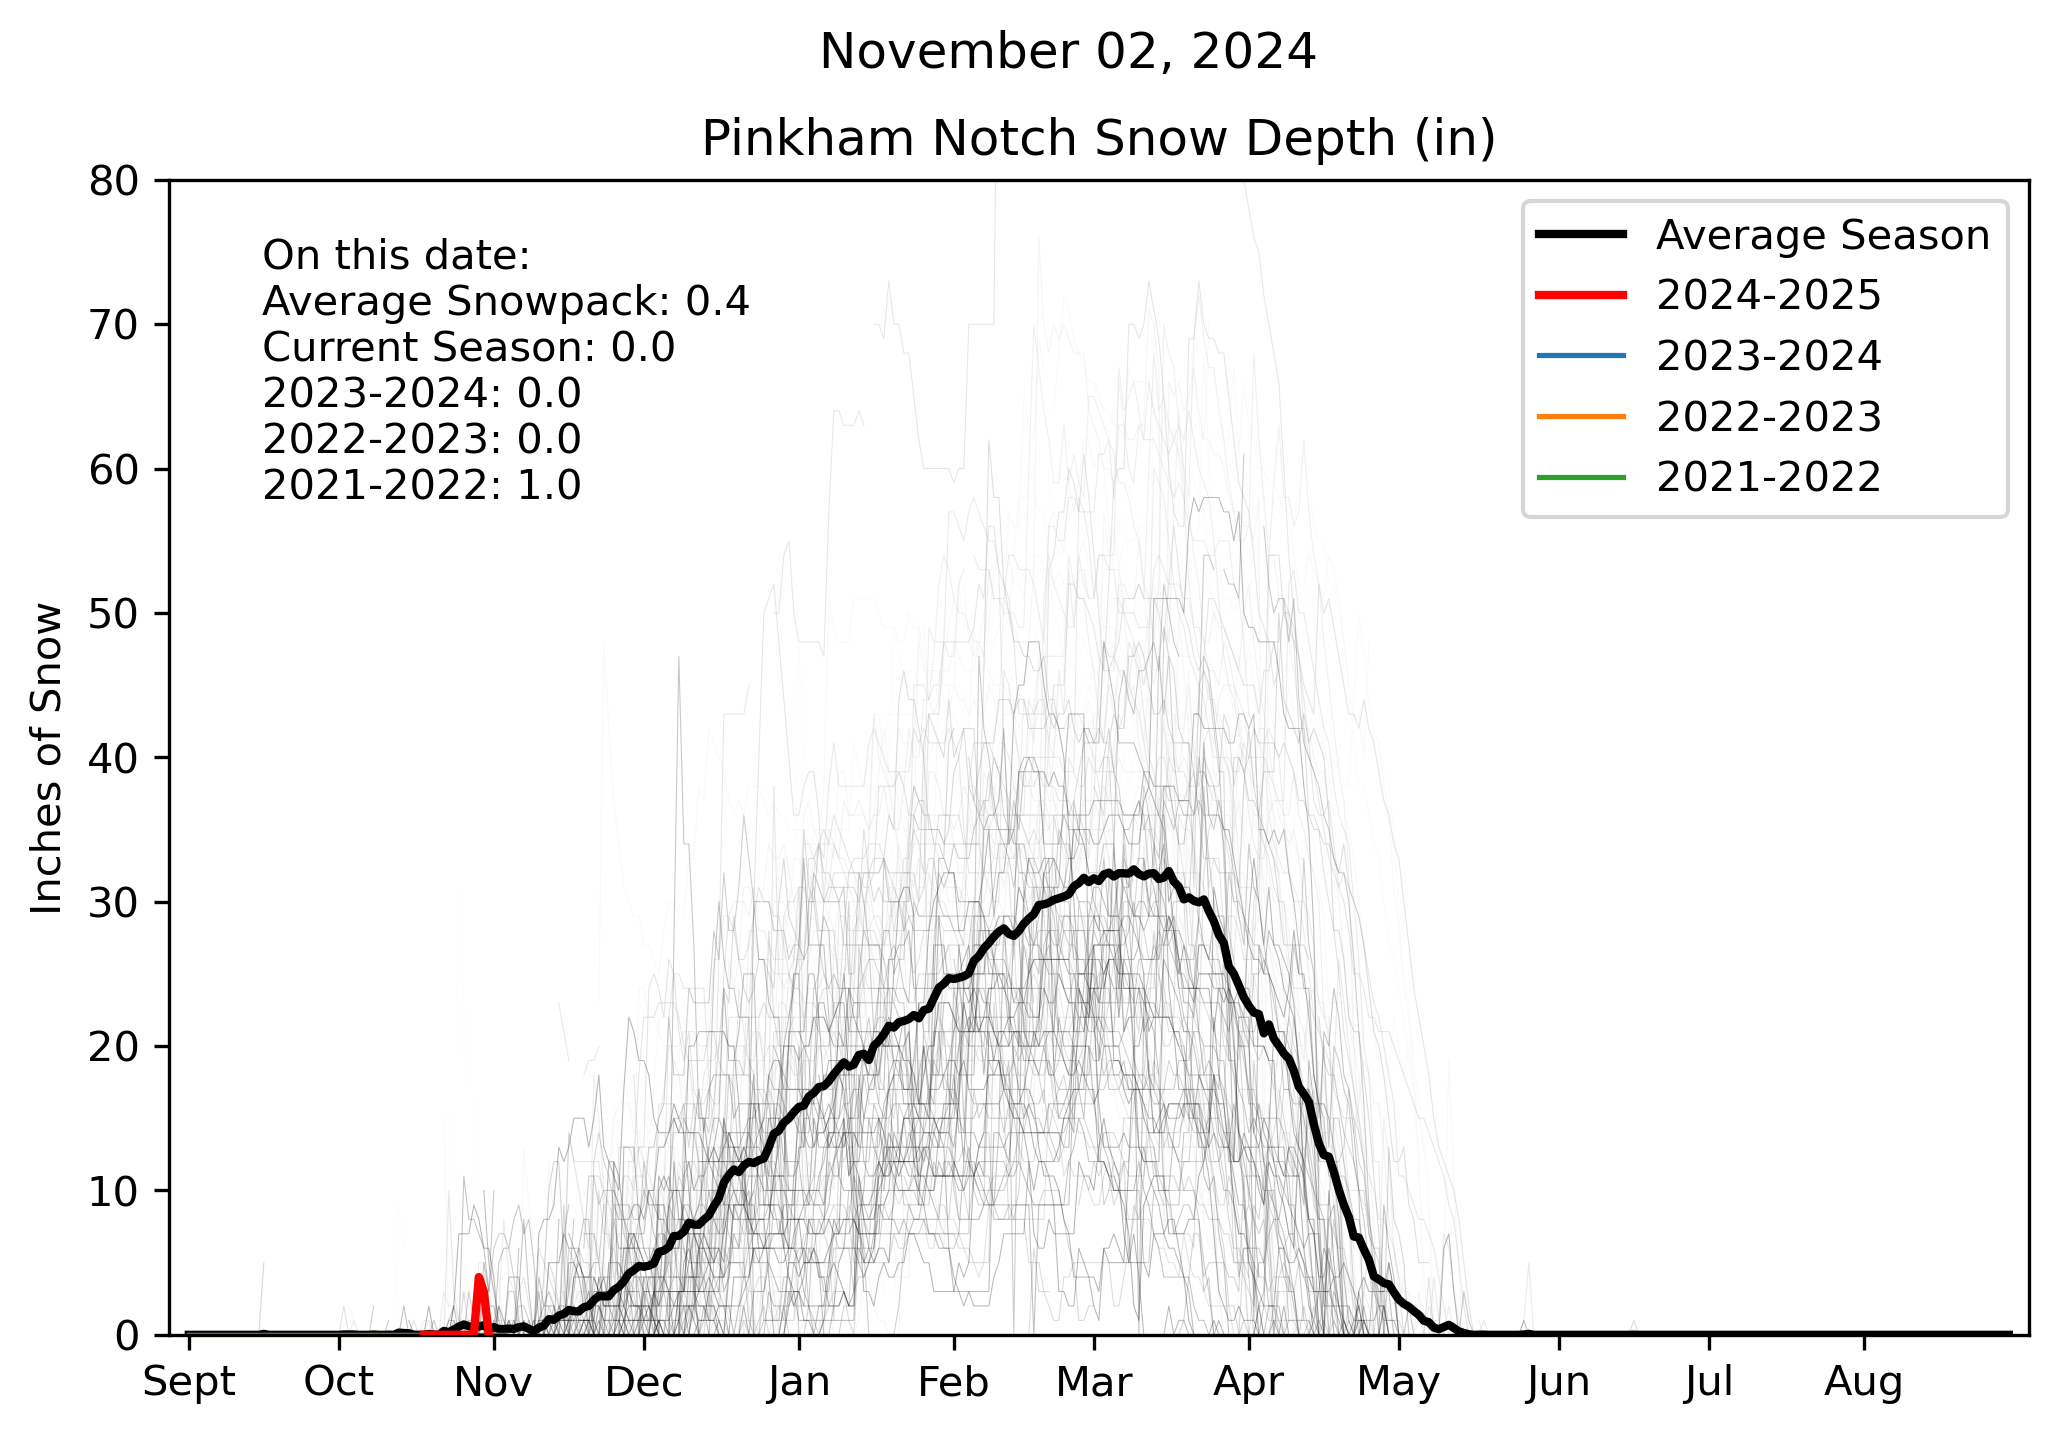

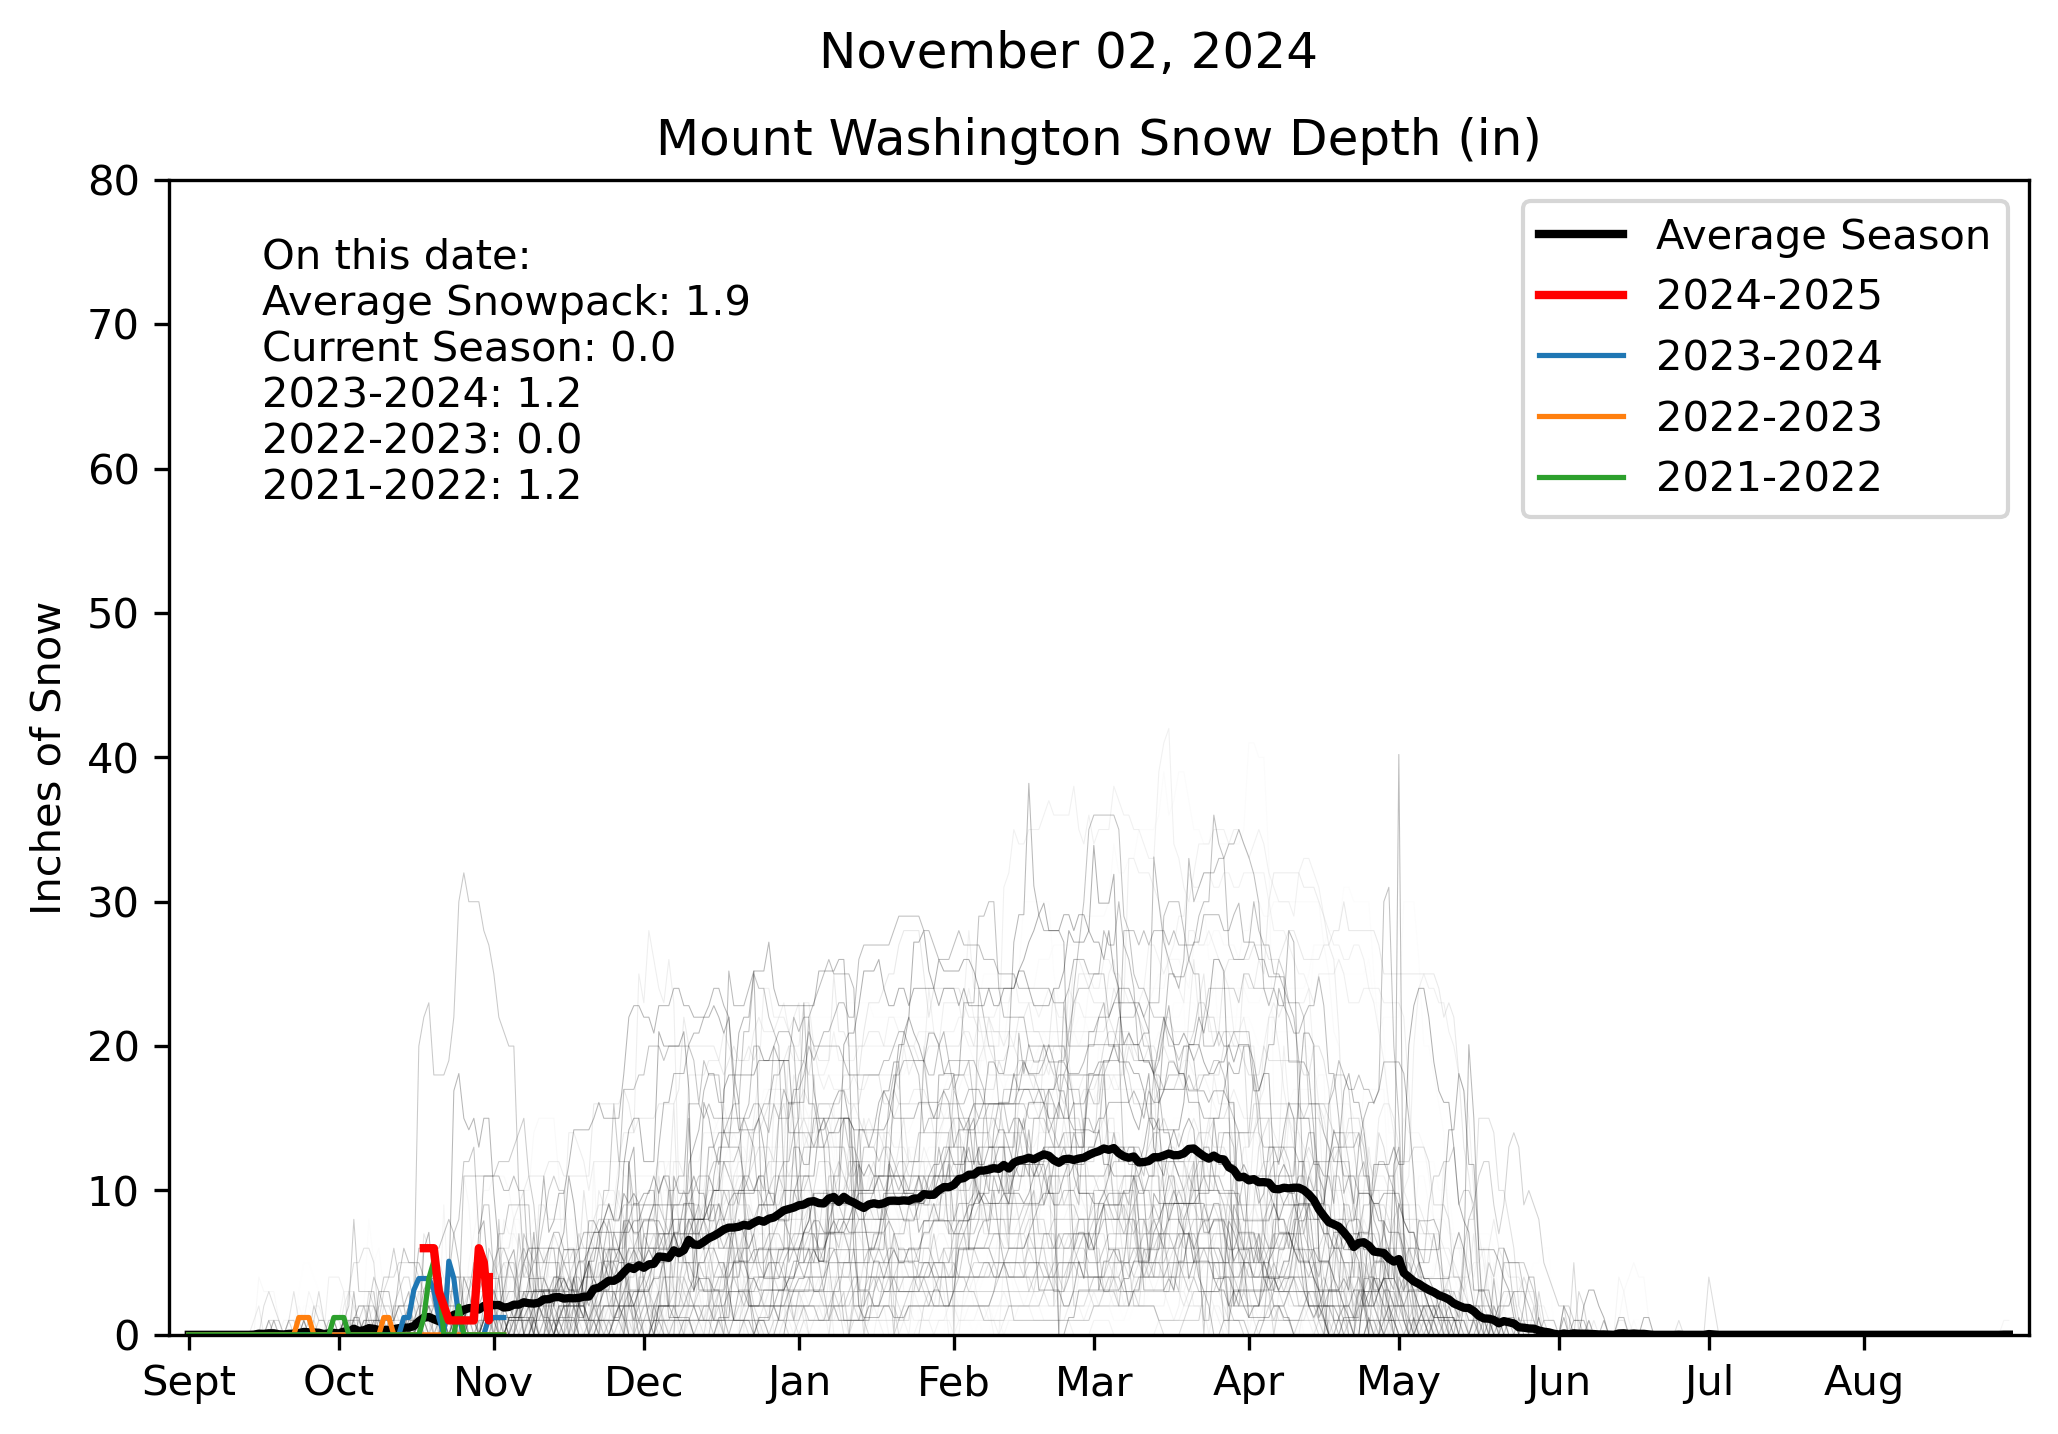

In [8]:
#### Load historical data for each station and plot, all in one loop ####

for stat in stationCodeList:
    currStationFolder = availableStationsDict[stat]
    stationFullName = availableStationsFullName[stat]
    snowDepthClim_IN = np.load('../data/historical/{}/{}SnowpackByYear_snowDepth.npy'.format(currStationFolder,currStationFolder))
    datesClim = np.load('../data/historical/{}/{}SnowpackByYear_endWinterYears.npy'.format(currStationFolder,currStationFolder))

    # Calculate Average
    averageSnowDepth_IN = np.nanmean(snowDepthClim_IN,axis=0)
    
    ################
    
    ### Make the plot ###

    fig, (ax1) = plt.subplots(1, 1,figsize=(8, 5),dpi=300)

    dayOfYear_startFromJan1 = date.today().timetuple().tm_yday
    if dayOfYear_startFromJan1 > 244:
        dayOfYear_startFromSept1 = dayOfYear_startFromJan1 + adjustToSept1 - 365
    else:
        dayOfYear_startFromSept1 = dayOfYear_startFromJan1 + adjustToSept1


    ## Plot station data and climatology ##

    # Put all of these years on a plot
    datesForPlotting = np.arange(1,366) # day 1 is Sept 1

    # Shading for historical plot
    n = len(snowDepthClim_IN)
    colors = plt.cm.Greys(np.linspace(0,1,n))

    # Plot the climatology
    for i in range(len(snowDepthClim_IN)):
        ax1.plot(datesForPlotting,snowDepthClim_IN[i],c=colors[i],linewidth = .25,alpha = .3,zorder=0)

    # Plot the average
    ax1.plot(datesForPlotting,averageSnowDepth_IN,label='Average Season',linewidth=2,color='k',zorder=1)
    
    # Get the average snow depth on today's date
    averageSnowDepthToday = averageSnowDepth_IN[dayOfYear_startFromSept1-1] # minus 1 because day 1 is index 0

    # Plot the current season
    ax1.plot(currentSeasonDatesDict[stat],currentSeasonSnowDepthDict_IN[stat],label='{}-{}'.format(currentYear-1,currentYear),linewidth=2,color='red',zorder=10)
    # get the current seasonal snowpack on this date
    currentSeasonSnowDepthToday = currentSeasonSnowDepthDict_IN[stat][currentSeasonDatesDict[stat]==dayOfYear_startFromSept1]
    if len(currentSeasonSnowDepthToday)==0:
        currentSeasonSnowDepthToday = 0.0
    else:
        currentSeasonSnowDepthToday = currentSeasonSnowDepthToday[0]

    # Highlight the last N years
    highlightLastNYears = 3
    seasonsToShow = ['{}-{}'.format(currentYear-i-1, currentYear-i) for i in range(1,highlightLastNYears+1)]
    datesUpToToday = np.arange(1,dayOfYear_startFromSept1 + 1)
    trackHistoricSnowDepthOnCurrDay = []
    for i in range(highlightLastNYears):
        ax1.plot(datesUpToToday,snowDepthClim_IN[-1-i][:len(datesUpToToday)],linewidth = 1.25,label=seasonsToShow[i])

        # Get the snow pack on this day in the last N years
        snowDepthInYear = snowDepthClim_IN[-1-i]
        snowDepthOnCurrentDay = snowDepthInYear[len(datesUpToToday)]
        trackHistoricSnowDepthOnCurrDay = trackHistoricSnowDepthOnCurrDay + [snowDepthOnCurrentDay]


    # Format Figure
    ax1.legend()
    ax1.set_xticks([dayOfYear('2001-09-01')+adjustToSept1-365, dayOfYear('2001-10-01')+adjustToSept1-365,
                dayOfYear('2001-11-01')+adjustToSept1-365, dayOfYear('2001-12-01')+adjustToSept1-365,
                dayOfYear('2001-01-01')+adjustToSept1, dayOfYear('2001-02-01')+adjustToSept1,
                dayOfYear('2001-03-01')+adjustToSept1, dayOfYear('2001-04-01')+adjustToSept1,
                dayOfYear('2001-05-01')+adjustToSept1, dayOfYear('2000-06-01')+adjustToSept1,
                dayOfYear('2000-07-01')+adjustToSept1, dayOfYear('2000-08-01')+adjustToSept1],
               ['Sept','Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug']);

    ax1.set_xlim([-3, 369])
    ax1.set_ylabel('Inches of Snow')

    ax1.set_title('{} Snow Depth (in)'.format(stationFullName))
    ax1.set_ylim([0, 80])

    today = date.today()
    d2 = today.strftime("%B %d, %Y")
    fig.suptitle(d2);

    # Make Text box

    stringForTextBox = 'On this date:'+ '\nAverage Snowpack: {} \nCurrent Season: {} \n'.format(round(averageSnowDepthToday,1),round(currentSeasonSnowDepthToday,1)) + historicSeasonStrings(seasonsToShow,trackHistoricSnowDepthOnCurrDay);

    ax1.text(0.05, 0.95, stringForTextBox, transform=ax1.transAxes, fontsize=10,
            verticalalignment='top');

    # Save the figure

    #plt.savefig('plot/images/pinkhamNotchSnowpack{}.png'.format(today.strftime("%b-%d-%Y")))
    #plt.savefig('plot/images/{}SnowpackTODAY.png'.format(currStationFolder))


In [10]:
currentSeasonSnowDepthDict_IN['KMWN']

array([6., 6., 6., 3., 2., 1., 1., 6., 5., 1., 4.])

In [12]:
currentSeasonDatesDict['KMWN']

array([48., 49., 50., 51., 52., 53., 58., 59., 60., 61., 61.])